# Quick Draw Modified CNN
Abel Tadesse <br />
Jason Yi <br />
Richy Chen <br />

## Import dependencies 

In [1]:
import os
import re
from glob import glob
from tqdm import tqdm
import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt
%matplotlib inline

How the training data looks: The data frame is a concatenation of 2 rows from each CSV file in the training set.


In [3]:
fnames = glob('./../train_simplified/*.csv')
cnames = ['countrycode', 'drawing', 'key_id', 'recognized', 'timestamp', 'word']
drawlist = []
for f in fnames[0:6]:
    first = pd.read_csv(f, nrows=10) # make sure we get a recognized drawing
    first = first[first.recognized==True].head(2)
    drawlist.append(first)
draw_df = pd.DataFrame(np.concatenate(drawlist), columns=cnames)
draw_df

,countrycode,drawing,key_id,recognized,timestamp,word
0,MD,"[[[41, 41, 49, 41, 42], [76, 110, 157, 201, 25...",5042528606748672,True,2017-03-11 21:58:33.282340,lollipop
1,FI,"[[[61, 65, 67], [98, 106, 255]], [[72, 66, 56,...",5232288554024960,True,2017-01-25 14:49:39.148020,lollipop
2,US,"[[[122, 102, 56, 45, 66], [0, 3, 3, 29, 22]], ...",5570004864991232,True,2017-03-16 05:55:20.812240,bench
3,AU,"[[[2, 1, 11, 101, 234, 250, 255], [70, 43, 16,...",5906426784382976,True,2017-03-10 05:48:45.775800,bench
4,US,"[[[0, 11, 14, 14, 7, 8, 14, 155, 187, 205, 210...",6320925102309376,True,2017-03-29 20:51:33.924090,dresser
5,VN,"[[[19, 15, 16, 23, 72, 138, 178, 182, 181, 189...",5963662059634688,True,2017-01-31 05:36:18.230000,dresser
6,AU,"[[[96, 84, 84, 101, 112, 115, 110, 103, 91, 86...",5212908118081536,True,2017-01-18 03:19:25.996870,scorpion
7,US,"[[[34, 19], [186, 223]], [[44, 47, 47, 41], [1...",6378657540997120,True,2017-03-30 20:32:16.099910,scorpion
8,BE,"[[[20, 12, 0, 1, 18, 24, 26, 25, 19], [134, 13...",4702418350637056,True,2017-03-26 21:51:40.742850,tractor
9,DE,"[[[125, 123, 107, 83, 54, 28, 6, 0, 2, 17, 42,...",4543922971869184,True,2017-01-26 19:32:14.264860,tractor


Example of how the sketches look:

In [4]:
evens = range(0,11,2)
odds = range(1,12, 2)
df1 = draw_df[draw_df.index.isin(evens)]
df2 = draw_df[draw_df.index.isin(odds)]

example1s = [ast.literal_eval(pts) for pts in df1.drawing.values]
example2s = [ast.literal_eval(pts) for pts in df2.drawing.values]

/home/abelleulseged/.local/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


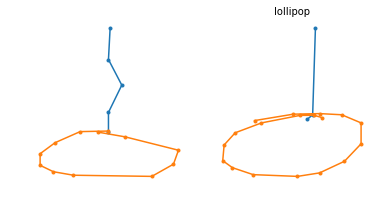

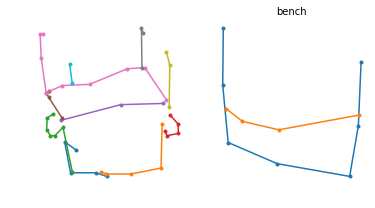

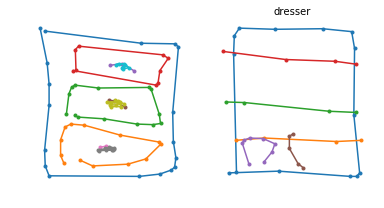

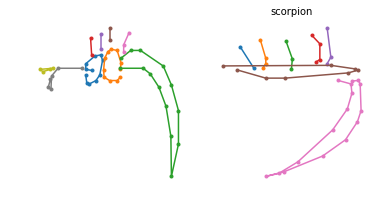

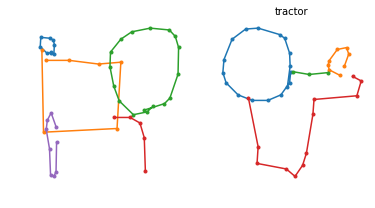

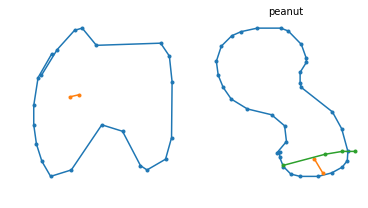

In [5]:
labels = df2.word.tolist()
for i, example in enumerate(example1s):
    plt.figure(figsize=(6,3))
    
    for x,y in example:
        plt.subplot(1,2,1)
        plt.plot(x, y, marker='.')
        plt.axis('off')

    for x,y, in example2s[i]:
        plt.subplot(1,2,2)
        plt.plot(x, y, marker='.')
        plt.axis('off')
        label = labels[i]
        plt.title(label, fontsize=10)

    plt.show()  

## Convolutional Neural Network (CNN) Implementation
Essentially an image classifier. Interprets the data as a 2D object with the strokes at completion. 


In [6]:
%reset -f 

In [7]:
#%% import
import os
from glob import glob
import re
import ast
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw 
from tqdm import tqdm
from dask import bag

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.metrics import top_k_categorical_accuracy
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [9]:
#%% set label dictionary and params
classfiles = os.listdir('./../train_simplified/')
numstonames = {i: v[:-4].replace(" ", "_") for i, v in enumerate(classfiles)} #adds underscores

num_classes = 50
imheight, imwidth = 32, 32  
ims_per_class = 2000  #max?

In [17]:
# faster conversion function
# Use PIL to make it faster to draw images
def draw_it(strokes):
    image = Image.new("P", (256,256), color=255)
    image_draw = ImageDraw.Draw(image)
    for stroke in ast.literal_eval(strokes):
        for i in range(len(stroke[0])-1):
            image_draw.line([stroke[0][i], 
                             stroke[1][i],
                             stroke[0][i+1], 
                             stroke[1][i+1]],
                            fill=0, width=5)
    image = image.resize((imheight, imwidth))
    return np.array(image)/255.

#%% get train arrays
# train = all drawings of that label
# trainarray = array representation of all those drawings in the label
# train_grand = list of list accumulator for all the array representations of drawings. 
train_grand = []
class_paths = glob('./../train_simplified/*.csv')
np.random.shuffle(class_paths)

In [18]:
for i,c in enumerate(tqdm(class_paths[0: num_classes])):
    #look at drawing and recognized columns
    train = pd.read_csv(c, usecols=['drawing', 'recognized'], nrows=ims_per_class*5//4)
    train = train[train.recognized == True].head(ims_per_class)
    # draws out the drawing values 
    imagebag = bag.from_sequence(train.drawing.values).map(draw_it) 
    # draw them at same time into np array
    trainarray = np.array(imagebag.compute())  
    trainarray = np.reshape(trainarray, (ims_per_class, -1))   
    # has all the label names for that specific label
    labelarray = np.full((train.shape[0], 1), i)
    # merge the labels and the drawings at every iteration and then stick it in one huge array
    trainarray = np.concatenate((labelarray, trainarray), axis=1)
    train_grand.append(trainarray)
    
train_grand = np.array([train_grand.pop() for i in np.arange(num_classes)]) #less memory than np.concatenate
train_grand = train_grand.reshape((-1, (imheight*imwidth+1)))

del trainarray
del train

100%|██████████| 50/50 [00:53<00:00,  1.14s/it]


In [19]:
# memory-friendly alternative to train_test_split?
# write the cut off point for splitting data between train and validation
valfrac = 0.1
cutpt = int(valfrac * train_grand.shape[0])

# shuffle the train_grand randomly
np.random.shuffle(train_grand)
# train gets last 90% and validation gets first 10%
# y represents the label (output) and the x represents the drawn image
y_train, X_train = train_grand[cutpt: , 0], train_grand[cutpt: , 1:]
y_val, X_val = train_grand[0:cutpt, 0], train_grand[0:cutpt, 1:] #validation set is recognized==True

del train_grand

# Encode labels with value between 0 and n_classes-1
y_train = keras.utils.to_categorical(y_train, num_classes)
# reshape the drawings to pixels
X_train = X_train.reshape(X_train.shape[0], imheight, imwidth, 1)
y_val = keras.utils.to_categorical(y_val, num_classes)
X_val = X_val.reshape(X_val.shape[0], imheight, imwidth, 1)

print(y_train.shape, "\n",
      X_train.shape, "\n",
      y_val.shape, "\n",
      X_val.shape)

(90000, 50) 
 (90000, 32, 32, 1) 
 (10000, 50) 
 (10000, 32, 32, 1)


# CNN architecture

In [20]:
model = Sequential()
# begin with 2D convolutional error instead of dense layer to prevent loss of spatial information
model.add(Conv2D(30, (5, 5), input_shape=(imheight, imwidth, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(15, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

# Dropout to account for possible overfitting
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 30)        780       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 30)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 15)        4065      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 15)          0         
_________________________________________________________________
flatten (Flatten)            (None, 540)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               69248     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
__________

In [21]:
def top_3_accuracy(x,y): 
    t3 = top_k_categorical_accuracy(x,y, 3)
    return t3
# save weights as you go and make checkpoint when value is better
weight_path="./{}_weights.hdf5".format('modified_cnn_model')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)
# monitor validation loss
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20, 
                                   verbose=1, mode='auto', min_delta=0.005, cooldown=5, min_lr=0.0001)
earlystop = EarlyStopping(monitor='val_top_3_accuracy', mode='max', patience=20) 
# while training, make these calls
callbacks = [reduceLROnPlat, earlystop, checkpoint]

In [22]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', top_3_accuracy])

In [23]:
history = model.fit(x=X_train, y=y_train,
          batch_size = 4096,
          epochs = 100,
          validation_data = (X_val, y_val),
          callbacks = callbacks,
          verbose = 1)

Train on 90000 samples, validate on 10000 samples
Epoch 1/100
86016/90000 [===========================>..] - ETA: 0s - loss: 3.8835 - acc: 0.0397 - top_3_accuracy: 0.0996
Epoch 00001: val_loss improved from inf to 3.76251, saving model to ./modified_cnn_model_weights.hdf5

Consider using a TensorFlow optimizer from `tf.train`.
90000/90000 [==============================] - 9s 104us/step - loss: 3.8800 - acc: 0.0403 - top_3_accuracy: 0.1010 - val_loss: 3.7625 - val_acc: 0.0711 - val_top_3_accuracy: 0.1565
Epoch 2/100
86016/90000 [===========================>..] - ETA: 0s - loss: 3.6457 - acc: 0.0726 - top_3_accuracy: 0.1803
Epoch 00002: val_loss improved from 3.76251 to 3.36004, saving model to ./modified_cnn_model_weights.hdf5

Consider using a TensorFlow optimizer from `tf.train`.
90000/90000 [==============================] - 3s 31us/step - loss: 3.6379 - acc: 0.0737 - top_3_accuracy: 0.1829 - val_loss: 3.3600 - val_acc: 0.1299 - val_top_3_accuracy: 0.3013
Epoch 3/100
86016/90000 [==

90000/90000 [==============================] - 3s 28us/step - loss: 2.4412 - acc: 0.3255 - top_3_accuracy: 0.5647 - val_loss: 2.1850 - val_acc: 0.4011 - val_top_3_accuracy: 0.6377
Epoch 12/100
86016/90000 [===========================>..] - ETA: 0s - loss: 2.3787 - acc: 0.3400 - top_3_accuracy: 0.5831
Epoch 00012: val_loss improved from 2.18498 to 2.10903, saving model to ./modified_cnn_model_weights.hdf5

Consider using a TensorFlow optimizer from `tf.train`.
90000/90000 [==============================] - 3s 28us/step - loss: 2.3766 - acc: 0.3405 - top_3_accuracy: 0.5833 - val_loss: 2.1090 - val_acc: 0.4168 - val_top_3_accuracy: 0.6593
Epoch 13/100
86016/90000 [===========================>..] - ETA: 0s - loss: 2.3199 - acc: 0.3543 - top_3_accuracy: 0.5995
Epoch 00013: val_loss improved from 2.10903 to 2.05900, saving model to ./modified_cnn_model_weights.hdf5

Consider using a TensorFlow optimizer from `tf.train`.
90000/90000 [==============================] - 3s 28us/step - loss: 2.31

86016/90000 [===========================>..] - ETA: 0s - loss: 1.9697 - acc: 0.4452 - top_3_accuracy: 0.6885
Epoch 00022: val_loss improved from 1.73307 to 1.70865, saving model to ./modified_cnn_model_weights.hdf5

Consider using a TensorFlow optimizer from `tf.train`.
90000/90000 [==============================] - 3s 29us/step - loss: 1.9694 - acc: 0.4453 - top_3_accuracy: 0.6887 - val_loss: 1.7087 - val_acc: 0.5266 - val_top_3_accuracy: 0.7547
Epoch 23/100
86016/90000 [===========================>..] - ETA: 0s - loss: 1.9402 - acc: 0.4519 - top_3_accuracy: 0.6979
Epoch 00023: val_loss improved from 1.70865 to 1.67820, saving model to ./modified_cnn_model_weights.hdf5

Consider using a TensorFlow optimizer from `tf.train`.
90000/90000 [==============================] - 3s 29us/step - loss: 1.9413 - acc: 0.4513 - top_3_accuracy: 0.6974 - val_loss: 1.6782 - val_acc: 0.5297 - val_top_3_accuracy: 0.7592
Epoch 24/100
86016/90000 [===========================>..] - ETA: 0s - loss: 1.9119 - 

90000/90000 [==============================] - 3s 29us/step - loss: 1.7647 - acc: 0.5009 - top_3_accuracy: 0.7385 - val_loss: 1.5085 - val_acc: 0.5817 - val_top_3_accuracy: 0.7969
Epoch 33/100
86016/90000 [===========================>..] - ETA: 0s - loss: 1.7480 - acc: 0.5024 - top_3_accuracy: 0.7419
Epoch 00033: val_loss improved from 1.50845 to 1.49408, saving model to ./modified_cnn_model_weights.hdf5

Consider using a TensorFlow optimizer from `tf.train`.
90000/90000 [==============================] - 3s 28us/step - loss: 1.7477 - acc: 0.5029 - top_3_accuracy: 0.7417 - val_loss: 1.4941 - val_acc: 0.5846 - val_top_3_accuracy: 0.7961
Epoch 34/100
86016/90000 [===========================>..] - ETA: 0s - loss: 1.7346 - acc: 0.5092 - top_3_accuracy: 0.7435
Epoch 00034: val_loss improved from 1.49408 to 1.48815, saving model to ./modified_cnn_model_weights.hdf5

Consider using a TensorFlow optimizer from `tf.train`.
90000/90000 [==============================] - 3s 29us/step - loss: 1.73

86016/90000 [===========================>..] - ETA: 0s - loss: 1.6292 - acc: 0.5363 - top_3_accuracy: 0.7657
Epoch 00043: val_loss improved from 1.39223 to 1.38803, saving model to ./modified_cnn_model_weights.hdf5

Consider using a TensorFlow optimizer from `tf.train`.
90000/90000 [==============================] - 3s 29us/step - loss: 1.6289 - acc: 0.5364 - top_3_accuracy: 0.7658 - val_loss: 1.3880 - val_acc: 0.6112 - val_top_3_accuracy: 0.8178
Epoch 44/100
86016/90000 [===========================>..] - ETA: 0s - loss: 1.6324 - acc: 0.5359 - top_3_accuracy: 0.7655
Epoch 00044: val_loss improved from 1.38803 to 1.38320, saving model to ./modified_cnn_model_weights.hdf5

Consider using a TensorFlow optimizer from `tf.train`.
90000/90000 [==============================] - 3s 28us/step - loss: 1.6318 - acc: 0.5361 - top_3_accuracy: 0.7653 - val_loss: 1.3832 - val_acc: 0.6167 - val_top_3_accuracy: 0.8161
Epoch 45/100
86016/90000 [===========================>..] - ETA: 0s - loss: 1.6108 - 

Epoch 54/100
86016/90000 [===========================>..] - ETA: 0s - loss: 1.5440 - acc: 0.5580 - top_3_accuracy: 0.7860
Epoch 00054: val_loss improved from 1.30865 to 1.30147, saving model to ./modified_cnn_model_weights.hdf5

Consider using a TensorFlow optimizer from `tf.train`.
90000/90000 [==============================] - 3s 28us/step - loss: 1.5431 - acc: 0.5587 - top_3_accuracy: 0.7859 - val_loss: 1.3015 - val_acc: 0.6336 - val_top_3_accuracy: 0.8314
Epoch 55/100
86016/90000 [===========================>..] - ETA: 0s - loss: 1.5318 - acc: 0.5632 - top_3_accuracy: 0.7867
Epoch 00055: val_loss did not improve from 1.30147
90000/90000 [==============================] - 3s 29us/step - loss: 1.5318 - acc: 0.5634 - top_3_accuracy: 0.7870 - val_loss: 1.3025 - val_acc: 0.6350 - val_top_3_accuracy: 0.8328
Epoch 56/100
86016/90000 [===========================>..] - ETA: 0s - loss: 1.5220 - acc: 0.5662 - top_3_accuracy: 0.7891
Epoch 00056: val_loss improved from 1.30147 to 1.28673, savin

86016/90000 [===========================>..] - ETA: 0s - loss: 1.4584 - acc: 0.5835 - top_3_accuracy: 0.8002
Epoch 00067: val_loss improved from 1.24373 to 1.23209, saving model to ./modified_cnn_model_weights.hdf5

Consider using a TensorFlow optimizer from `tf.train`.
90000/90000 [==============================] - 3s 28us/step - loss: 1.4574 - acc: 0.5835 - top_3_accuracy: 0.8005 - val_loss: 1.2321 - val_acc: 0.6543 - val_top_3_accuracy: 0.8431
Epoch 68/100
86016/90000 [===========================>..] - ETA: 0s - loss: 1.4512 - acc: 0.5844 - top_3_accuracy: 0.8025
Epoch 00068: val_loss improved from 1.23209 to 1.22547, saving model to ./modified_cnn_model_weights.hdf5

Consider using a TensorFlow optimizer from `tf.train`.
90000/90000 [==============================] - 3s 29us/step - loss: 1.4529 - acc: 0.5841 - top_3_accuracy: 0.8023 - val_loss: 1.2255 - val_acc: 0.6502 - val_top_3_accuracy: 0.8453
Epoch 69/100
86016/90000 [===========================>..] - ETA: 0s - loss: 1.4485 - 

90000/90000 [==============================] - 3s 29us/step - loss: 1.3969 - acc: 0.5994 - top_3_accuracy: 0.8138 - val_loss: 1.1858 - val_acc: 0.6618 - val_top_3_accuracy: 0.8520
Epoch 82/100
86016/90000 [===========================>..] - ETA: 0s - loss: 1.3935 - acc: 0.6000 - top_3_accuracy: 0.8145
Epoch 00082: val_loss did not improve from 1.18577
90000/90000 [==============================] - 3s 29us/step - loss: 1.3935 - acc: 0.6001 - top_3_accuracy: 0.8144 - val_loss: 1.1964 - val_acc: 0.6592 - val_top_3_accuracy: 0.8515
Epoch 83/100
86016/90000 [===========================>..] - ETA: 0s - loss: 1.3947 - acc: 0.6015 - top_3_accuracy: 0.8136
Epoch 00083: val_loss improved from 1.18577 to 1.18012, saving model to ./modified_cnn_model_weights.hdf5

Consider using a TensorFlow optimizer from `tf.train`.
90000/90000 [==============================] - 3s 29us/step - loss: 1.3962 - acc: 0.6013 - top_3_accuracy: 0.8134 - val_loss: 1.1801 - val_acc: 0.6649 - val_top_3_accuracy: 0.8519
Epo

90000/90000 [==============================] - 3s 28us/step - loss: 1.3394 - acc: 0.6159 - top_3_accuracy: 0.8245 - val_loss: 1.1496 - val_acc: 0.6703 - val_top_3_accuracy: 0.8573
Epoch 98/100
86016/90000 [===========================>..] - ETA: 0s - loss: 1.3437 - acc: 0.6131 - top_3_accuracy: 0.8237
Epoch 00098: val_loss improved from 1.14961 to 1.14439, saving model to ./modified_cnn_model_weights.hdf5

Consider using a TensorFlow optimizer from `tf.train`.
90000/90000 [==============================] - 3s 29us/step - loss: 1.3437 - acc: 0.6133 - top_3_accuracy: 0.8238 - val_loss: 1.1444 - val_acc: 0.6695 - val_top_3_accuracy: 0.8557
Epoch 99/100
86016/90000 [===========================>..] - ETA: 0s - loss: 1.3322 - acc: 0.6172 - top_3_accuracy: 0.8267
Epoch 00099: val_loss did not improve from 1.14439
90000/90000 [==============================] - 3s 28us/step - loss: 1.3318 - acc: 0.6171 - top_3_accuracy: 0.8268 - val_loss: 1.1496 - val_acc: 0.6727 - val_top_3_accuracy: 0.8561
Epo

In [24]:
model.load_weights(weight_path)

dict_keys(['val_loss', 'val_acc', 'val_top_3_accuracy', 'loss', 'acc', 'top_3_accuracy', 'lr'])


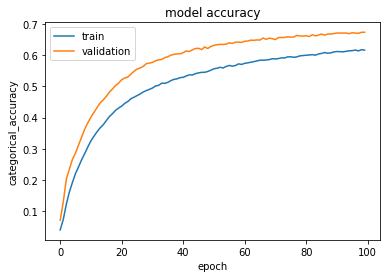

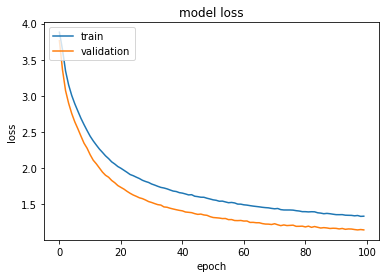

In [25]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Predictions on test set


In [27]:
#%% get test set
ttvlist = []
reader = pd.read_csv('./../test_simplified.csv', index_col=['key_id'],
    chunksize=2048)
for chunk in tqdm(reader, total=55):
    imagebag = bag.from_sequence(chunk.drawing.values).map(draw_it)
    testarray = np.array(imagebag.compute())
    testarray = np.reshape(testarray, (testarray.shape[0], imheight, imwidth, 1))
    testpreds = model.predict(testarray, verbose=0)
    ttvs = np.argsort(-testpreds)[:, 0:3]  # top 3
    ttvlist.append(ttvs)
    
ttvarray = np.concatenate(ttvlist)

100%|██████████| 55/55 [01:18<00:00,  1.36s/it]


In [29]:
preds_df = pd.DataFrame({'first': ttvarray[:,0], 'second': ttvarray[:,1], 'third': ttvarray[:,2]})
preds_df = preds_df.replace(numstonames)
preds_df['words'] = preds_df['first'] + " " + preds_df['second'] + " " + preds_df['third']

sub = pd.read_csv('./../sample_submission.csv', index_col=['key_id'])
sub['word'] = preds_df.words.values
sub.to_csv('cnn_mod.csv')
sub.head()

,word
key_id,
9000003627287624,spoon paintbrush boomerang
9000010688666847,tractor paper_clip dragon
9000023642890129,face The_Eiffel_Tower dresser
9000038588854897,lollipop stethoscope angel
9000052667981386,boomerang stethoscope speedboat
